In [1]:
# Purpose: Quickly analysing ENSOWind EXP to see if all okay
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                                                                                       
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import warnings
import matplotlib.path as mpath
import time
import matplotlib.animation as animation # library that makes the movie
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
from cosima_cookbook import explore
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m

#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

CPU times: user 1.91 s, sys: 461 ms, total: 2.37 s
Wall time: 3.03 s


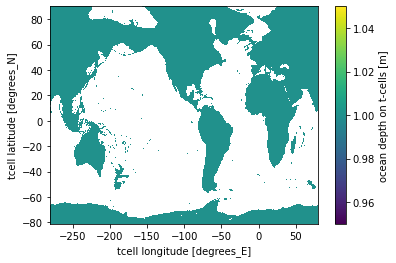

In [13]:
%%time
# first get the shelf mask
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu; above1000 = field.where(field >= 1000,1); above1000_ucells = above1000.where(above1000 < 1000, drop=False) 
# Wall time: 8.74 s
above1000_tcells.plot()

### Load in temperatures and velocities

In [14]:
%%time
session = cc.database.create_session()
dbx = explore.DatabaseExplorer(session=session)
dbx

CPU times: user 56.8 s, sys: 6.34 s, total: 1min 3s
Wall time: 56.6 s


DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

In [15]:
cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='temp', 
                                    session=session, frequency='1 daily',
                                    attrs={'cell_methods': 'time: mean'},
                                    start_time='2012-12-01 00:00:00', 
                                    end_time='2017-04-01 00:00:00', 
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})

,Array,Chunk
Bytes,4.35 TiB,143.68 MiB
Shape,"(1642, 75, 2700, 3600)","(31, 75, 108, 150)"
Count,184054 Tasks,54000 Chunks
Type,float32,numpy.ndarray


In [16]:
%%time
# ---------------------------------------------------------------------------------- #
time      = [   3,   31]  # [  30, 1613] = 2012-12-01 to 2017-04-01 just like SOSE   #
depth     = [   0,   47]  # [  0,    47] = 0.5 m - 1017 m                            #
sel_lat   = [   0,  500]  # [120,   263] = 76.03°S - 70.04°S                         #
sel_lon   = [1299, 2200]  # 150°W - 60°W                                             #
# ---------------------------------------------------------------------------------- #
vars = ['temp', 'wt']
freq = ['1 monthly', '1 daily']
for r in range(2): # loop through the monthly and daily data
    for f in range(2):
        print('get '+freq[r]+' data '+vars[f])
        variable = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable=vars[f], 
                                            session=session, frequency=freq[r],
                                            attrs={'cell_methods': 'time: mean'},
                                            start_time='2012-01-01 00:00:00', 
                                            end_time='2012-12-31 00:00:00', 
                                            chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[time[r]:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
        if r == 0 and f == 0: temp_monthly = variable
        if r == 0 and f == 1: wt_monthly   = variable
        if r == 1 and f == 0: temp_daily   = variable
        if r == 1 and f == 1: wt_daily = variable

        # first, get climatological shelf temperature range in °C
        if f == 0:
            print('calculating temp range')
            clim = ((variable*above1000_tcells).mean('time')[depth[0],:,:] - 273.15).load()
            clim_range = np.nanpercentile(clim, 95) - np.nanpercentile(clim, 5)

    if r == 0: clim_range_monthly = clim_range
    if r == 1: clim_range_daily   = clim_range
# Wall time: 1min 52s

get 1 monthly data temp
calculating temp range
get 1 monthly data wt
get 1 daily data temp
calculating temp range
get 1 daily data wt
CPU times: user 11.9 s, sys: 2.37 s, total: 14.3 s
Wall time: 1min 23s


### Calculate the vertical heat flux + uncertainty

In [17]:
%%time
# get the grid cell area and ocean depth, select West Antarctic shelf region and interpolate to dTdz grid
base_grid = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean'
rho_0 = 1035.0                       # [kg m^{-3}]
C_p   = 3992.10322329649               # [J kg^{-1} K^{-1}]
area_t = xr.open_mfdataset(base_grid+'_grid.nc').area_t[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
dyt    = xr.open_mfdataset(base_grid+'_grid.nc').dyt[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
above1000 = above1000_tcells[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

CPU times: user 60.3 ms, sys: 7.83 ms, total: 68.1 ms
Wall time: 55.1 ms


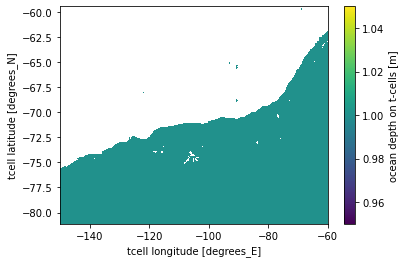

In [23]:
above1000.plot()

### Updating the bathymetry mask

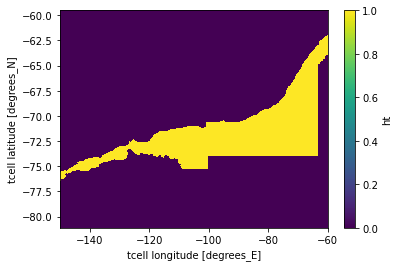

In [29]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht

bath_mask = xr.where(field.isel(xt_ocean=slice(1299,2200),yt_ocean=slice(0,500))<=1000,1,0)
bath_mask[:396,886:] = bath_mask[:396,886:].where(bath_mask[:396,886:]!=1, 0) # manually mask out all the other sea mounts and the region
bath_mask[:170,500:] = bath_mask[:170,500:].where(bath_mask[:170,500:]!=1, 0) # in the western Weddell Sea
bath_mask[270:,:670] = bath_mask[270:,:670].where(bath_mask[270:,:670]!=1, 0)
bath_mask[410:,:840] = bath_mask[410:,:840].where(bath_mask[410:,:840]!=1, 0)
bath_mask[:390,878:] = bath_mask[:390,878:].where(bath_mask[:390,878:]!=1, 0)

# and also unmasking the grid cells that are seamounts on the shelf
bath_mask[145:160,100:120] = bath_mask[145:160,100:120].where(bath_mask[145:160,100:120]!=0, 1)
bath_mask[169:175,313:333] = bath_mask[169:175,313:333].where(bath_mask[169:175,313:333]!=0, 1)
bath_mask[175:210,313:400] = bath_mask[175:210,313:400].where(bath_mask[175:210,313:400]!=0, 1)
bath_mask[166:225,340:351] = bath_mask[166:225,340:351].where(bath_mask[166:225,340:351]!=0, 1)
bath_mask[139:225,410:500] = bath_mask[139:225,410:500].where(bath_mask[139:225,410:500]!=0, 1)
bath_mask[170:220,620:790] = bath_mask[170:220,620:790].where(bath_mask[170:220,620:790]!=0, 1)
bath_mask[200:287,720:870] = bath_mask[200:287,720:870].where(bath_mask[200:287,720:870]!=0, 1)
bath_mask[270:310,760:870] = bath_mask[270:310,760:870].where(bath_mask[270:310,760:870]!=0, 1)
bath_mask[300:345,785:870] = bath_mask[300:345,785:870].where(bath_mask[300:345,785:870]!=0, 1)
bath_mask[340:380,815:870] = bath_mask[340:380,815:870].where(bath_mask[340:380,815:870]!=0, 1)
bath_mask[340:410,855:870] = bath_mask[340:410,855:870].where(bath_mask[340:410,855:870]!=0, 1)
bath_mask[389:425,868:874] = bath_mask[389:425,868:874].where(bath_mask[389:425,868:874]!=0, 1)
bath_mask[393:425,868:884] = bath_mask[393:425,868:884].where(bath_mask[393:425,868:884]!=0, 1)
bath_mask[400:425,868:890] = bath_mask[400:425,868:890].where(bath_mask[400:425,868:890]!=0, 1)
bath_mask[407:438,873:] = bath_mask[407:438,873:].where(bath_mask[407:438,873:]!=0, 1)
bath_mask[407:445,890:] = bath_mask[407:445,890:].where(bath_mask[407:445,890:]!=0, 1)
bath_mask[170:250,490:870] = bath_mask[170:250,490:870].where(bath_mask[170:250,490:870]!=0, 1)
above1000 = bath_mask
above1000.plot()

CPU times: user 1.03 s, sys: 121 ms, total: 1.15 s
Wall time: 3.32 s


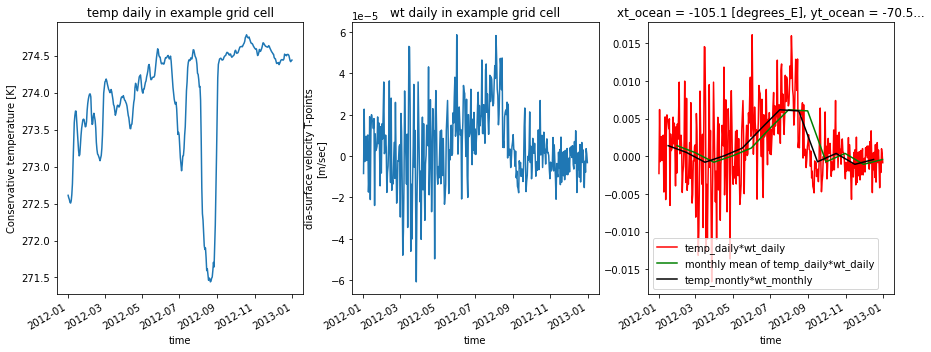

In [33]:
%%time
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
temp_daily[:,23,250,450].plot(); plt.title('temp daily in example grid cell')
plt.subplot(1,3,2)
wt_daily[:,23,250,450].plot(); plt.title('wt daily in example grid cell')
plt.subplot(1,3,3)

(temp_daily[:,23,250,450]*wt_daily[:,23,250,450]).plot(c='r', label='temp_daily*wt_daily')
(temp_daily[:,23,250,450]*wt_daily[:,23,250,450]).resample(time='M').mean('time').plot(c='g', label='monthly mean of temp_daily*wt_daily')
(temp_monthly[:,23,250,450]*wt_monthly[:,23,250,450]).plot(c='k', label='temp_montly*wt_monthly'); plt.legend()
# Wall time: 3.04 s

In [34]:
%%time
average_DT = xr.open_mfdataset('/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_LNFull/' + 
                               'output*/ocean/ocean_month.nc', decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 # average time in seconds per month (the output is saved in ns, that's why /1e9) 

for r in range(2):
    if r == 0: 
        wt = wt_monthly; temp = temp_monthly; clim_range = clim_range_monthly
    if r == 1: 
        wt = wt_daily;   temp = temp_daily;   clim_range = clim_range_daily
    
    # here the calculation of the vertical heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) --------------------------------------------------- #
    vertical_heat_flux = (rho_0 * C_p * wt[:,23,:,:] * temp[:,23,:,:] * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']).load()
    # and now also the uncertainties - clim_range = (\Delta\Theta)^{max} = 2.39°C 
    vertical_heat_flux_uncertainty = (rho_0 * C_p * wt[:,23,:,:] * clim_range / 2 * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']).load()
    
    if r == 0: 
        vertical_heat_flux_monthly             = vertical_heat_flux
        vertical_heat_flux_uncertainty_monthly = vertical_heat_flux_uncertainty
    if r == 1:
        vertical_heat_flux_daily               = vertical_heat_flux
        vertical_heat_flux_uncertainty_daily   = vertical_heat_flux_uncertainty
    print('simulation done')
# Wall time: 59 s

simulation done
simulation done
CPU times: user 11.2 s, sys: 1.4 s, total: 12.6 s
Wall time: 43.7 s


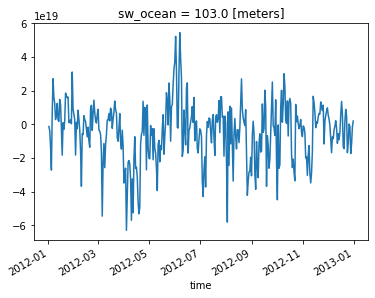

In [35]:
vertical_heat_flux_uncertainty_daily.plot()

CPU times: user 1.93 s, sys: 177 ms, total: 2.11 s
Wall time: 1.91 s


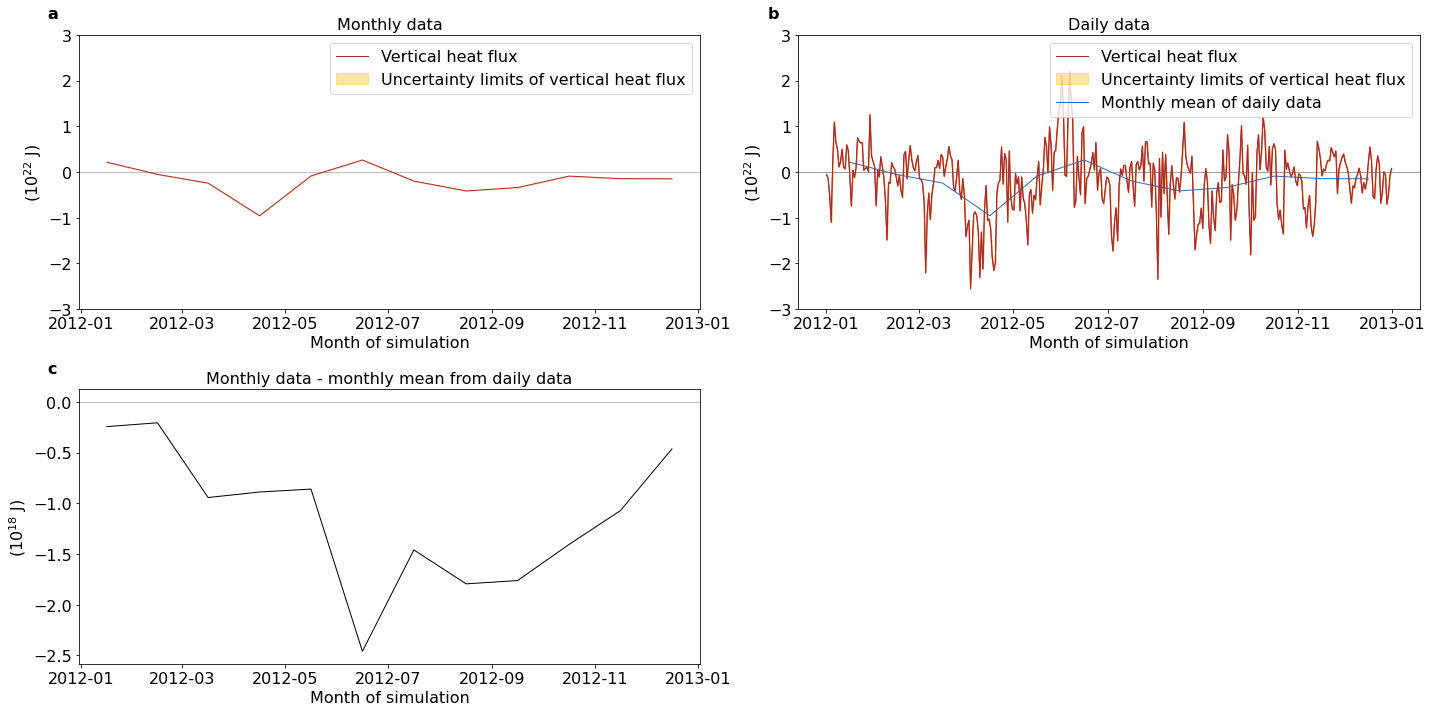

In [36]:
%%time
filename= 'Comparison_simulated_N34_and_JRA55-do'

# initialise figure
fig = plt.figure(figsize=(20,10),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2) 

time_monthly        = vertical_heat_flux_monthly.time
time_daily          = vertical_heat_flux_daily.time
for f in range(3):
    if f == 0: 
        ax1 = plt.subplot(gs[0,0]); plt.title('Monthly data', fontsize=16)
        time= time_monthly
        vertical    = vertical_heat_flux_monthly
        uncertainty = vertical_heat_flux_uncertainty_monthly
    if f == 1: 
        ax1 = plt.subplot(gs[0,1]); plt.title('Daily data', fontsize=16)
        time = time_daily
        vertical    = vertical_heat_flux_daily
        uncertainty = vertical_heat_flux_uncertainty_daily
       
    plt.axhline(linewidth=.5, c='grey')
    plt.plot(time, vertical/1e22, label = 'Vertical heat flux', linewidth=1, c=rotblau[3])
    ax1.fill_between(time, (vertical+uncertainty)/1e22, (vertical-uncertainty)/1e22, color='orange', alpha=.3, label= 'Uncertainty limits of vertical heat flux', linewidth=1)

    if f == 1:
            plt.plot(time_monthly, (vertical.groupby('time.month').mean('time'))/1e22, color=rotblau[17], label = 'Monthly mean of daily data', linewidth=1)

    if f == 2:
        ax1 = plt.subplot(gs[1,0]); plt.title('Daily data', fontsize=16)
        plt.axhline(linewidth=.5, c='grey') # horizontal line at 0
        plt.plot(time_monthly, (vertical_heat_flux_monthly - vertical.groupby('time.month').mean('time').values)/1e18, linewidth=1, color='k')
        plt.title('Monthly data - monthly mean from daily data', fontsize=16)

    if f in [0, 1]: plt.legend(fontsize=16)
    if f in [0,1]: plt.ylim([-3,3]); ax1.set_ylabel('(10$^{22}$ J)', color='k', fontsize=16) # hide x-axis label
    if f in [2]: ax1.set_ylabel('(10$^{18}$ J)', color='k', fontsize=16) # hide x-axis label
    ax1.tick_params(axis='y', labelcolor='k')

    

    ax1.set_xlabel('Month of simulation', color='k', fontsize=16) # x-axis label
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)

    ax1.text(-.05, 1.06, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
# fig.legend(ncol=2, fontsize=16, bbox_to_anchor=(.5, -.25), loc='lower center')
# --- saving as 300 dpi .PNG image in specified folder --------------- #
plt.savefig(save + filename+'difference_between_monthly_and_daily_fluxes', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,    #
            format=None, transparent=False, bbox_inches='tight',       #
            pad_inches=0.1, metadata=None)                             #
# --- end of script -------------------------------------------------- # 
# Wall time: 1min 32s

# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #

In [11]:
uncertainty

<xarray.DataArray (time: 366)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
    sw_ocean  float64 103.0
  * time      (time) datetime64[ns] 2012-01-01T12:00:00 ... 2012-12-31T12:00:00

In [12]:
a

NameError: name 'a' is not defined

In [ ]:
a